In [85]:
#unique_age_milestones = df['Dimension'].unique()


In [86]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot


In [87]:
df = pd.read_csv("Datasets/Vaccination_Coverage_among_Young_Children__0-35_Months__20241101.csv")

In [88]:
# Define the state-to-region mapping for the 9 census regions
state_to_region = {
    # Middle Atlantic
    'New York': 'Middle Atlantic', 'NY-Rest of state': 'Middle Atlantic', 'NY-City of New York': 'Middle Atlantic', 
    'New Jersey': 'Middle Atlantic', 'Pennsylvania': 'Middle Atlantic', 
    'PA-Philadelphia': 'Middle Atlantic', 'PA-Rest of state': 'Middle Atlantic',

    # New England
    'Vermont': 'New England', 'New Hampshire': 'New England', 'Massachusetts': 'New England', 
    'Connecticut': 'New England', 'Rhode Island': 'New England', 'Maine': 'New England',

    # East North Central
    'Indiana': 'East North Central', 'Illinois': 'East North Central', 'Michigan': 'East North Central', 
    'Ohio': 'East North Central', 'Wisconsin': 'East North Central', 
    'IL-City of Chicago': 'East North Central', 'IL-Rest of state': 'East North Central',

    # West North Central
    'Iowa': 'West North Central', 'Kansas': 'West North Central', 'Minnesota': 'West North Central',
    'Missouri': 'West North Central', 'Nebraska': 'West North Central', 
    'North Dakota': 'West North Central', 'South Dakota': 'West North Central',

    # South Atlantic
    'Delaware': 'South Atlantic', 'District of Columbia': 'South Atlantic', 'Florida': 'South Atlantic', 
    'Georgia': 'South Atlantic', 'Maryland': 'South Atlantic', 'North Carolina': 'South Atlantic', 
    'South Carolina': 'South Atlantic', 'Virginia': 'South Atlantic', 'West Virginia': 'South Atlantic',

    # East South Central
    'Alabama': 'East South Central', 'Kentucky': 'East South Central', 
    'Mississippi': 'East South Central', 'Tennessee': 'East South Central', 

    # West South Central
    'Arkansas': 'West South Central', 'Louisiana': 'West South Central', 'Oklahoma': 'West South Central', 
    'Texas': 'West South Central', 'TX-City of Houston': 'West South Central', 
    'TX-Rest of state': 'West South Central', 'TX-Dallas County': 'West South Central', 
    'TX-Bexar County': 'West South Central', 'TX-El Paso County': 'West South Central', 
    'TX-Hidalgo County': 'West South Central', 'TX-Tarrant County': 'West South Central',

    # Mountain
    'Arizona': 'Mountain', 'Colorado': 'Mountain', 'Idaho': 'Mountain', 
    'New Mexico': 'Mountain', 'Montana': 'Mountain', 'Utah': 'Mountain', 
    'Nevada': 'Mountain', 'Wyoming': 'Mountain',

    # Pacific
    'Alaska': 'Pacific', 'California': 'Pacific', 'Hawaii': 'Pacific', 
    'Oregon': 'Pacific', 'Washington': 'Pacific'
}


In [89]:
df = df[df['Vaccine'] == 'DTaP']



unique_vaccines = df['Vaccine'].unique()
print("Unique values in 'Vaccine' column after filtering:", unique_vaccines)

Unique values in 'Vaccine' column after filtering: ['DTaP']


In [90]:
# Filter for 2020-2021 Birth Cohort
df = df[df['Birth Year/Birth Cohort'].str.contains('2020|2021', na=False)]

In [91]:
# Filter to include only rows where 'Dimension Type' is 'Age'
df_filtered = df[df['Dimension Type'] == 'Age']

# Map Census Region and handle any unmapped entries as 'Unknown'
df_filtered['Census Region'] = df_filtered['Geography'].map(state_to_region).fillna('Unknown')

# Filter out rows with 'Unknown' regions if they exist
df_filtered = df_filtered[df_filtered['Census Region'] != 'Unknown']

# Extract the age in months from the 'Dimension' column
df_filtered['Age Milestone (months)'] = df_filtered['Dimension'].str.extract(r'(\d+)').astype(float)

# Drop any rows with missing values in relevant columns
df_filtered = df_filtered.dropna(subset=['Age Milestone (months)', 'Census Region', 'Estimate (%)'])

# Convert Estimate (%) to numeric if not already
df_filtered['Estimate (%)'] = pd.to_numeric(df_filtered['Estimate (%)'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['Estimate (%)'])



In [92]:
# Run Two-Way ANOVA for Region and Age with interaction
model = ols('Q("Estimate (%)") ~ Q("Census Region") + Q("Age Milestone (months)") + Q("Census Region"):Q("Age Milestone (months)")', data=df_filtered).fit()
anova_results = anova_lm(model, typ=2)

# Display ANOVA table for interpretation
print("\nANOVA Results:\n", anova_results)

# Check if p-value for Census Region is significant (< 0.01) to justify running Tukey's test
if anova_results.loc['Q("Census Region")', 'PR(>F)'] < 0.01:
    tukey = pairwise_tukeyhsd(endog=df_filtered['Estimate (%)'], groups=df_filtered['Census Region'], alpha=0.01)
    print("\nTukey HSD Test Results:\n", tukey)

# Additional output for F and p-values for easier reference
print("\nF and p-values for each effect in the ANOVA:")
for effect in ['Q("Census Region")', 'Q("Age Milestone (months)")', 'Q("Census Region"):Q("Age Milestone (months)")']:
    f_value = anova_results.loc[effect, 'F']
    p_value = anova_results.loc[effect, 'PR(>F)']
    print(f"{effect} - F-value: {f_value}, p-value: {p_value}")


ANOVA Results:
                                                        sum_sq      df  \
Q("Census Region")                               11559.211081     8.0   
Q("Age Milestone (months)")                      24090.388108     1.0   
Q("Census Region"):Q("Age Milestone (months)")     701.836726     8.0   
Residual                                        154580.822418  2382.0   

                                                         F        PR(>F)  
Q("Census Region")                               22.265085  4.934921e-33  
Q("Age Milestone (months)")                     371.218781  5.428739e-77  
Q("Census Region"):Q("Age Milestone (months)")    1.351862  2.130543e-01  
Residual                                               NaN           NaN  

Tukey HSD Test Results:
              Multiple Comparison of Means - Tukey HSD, FWER=0.01             
      group1             group2       meandiff p-adj   lower    upper  reject
------------------------------------------------------------

In [93]:
# Check unique values in 'Dimension Type' to confirm only 'Age' is present
unique_dimension_types = df_filtered['Dimension Type'].unique()
print("Unique values in 'Dimension Type':", unique_dimension_types)


Unique values in 'Dimension Type': ['Age']


In [94]:
# Check unique values in 'Dimension' to ensure they only contain age milestones
unique_dimensions = df_filtered['Dimension'].unique()
print("Unique values in 'Dimension':", unique_dimensions)


Unique values in 'Dimension': ['5 Months' '13 Months' '35 Months' '24 Months' '19 Months' '7 Months'
 '3 Months']


In [95]:
df_filtered.sample(50)

,Vaccine,Dose,Geography Type,Geography,Birth Year/Birth Cohort,Dimension Type,Dimension,Estimate (%),95% CI (%),Sample Size,Census Region,Age Milestone (months)
13408,DTaP,≥1 Dose,States/Local Areas,Alabama,2021,Age,3 Months,83.2,72.5 to 90.3,160.0,East South Central,3.0
32996,DTaP,≥3 Doses,States/Local Areas,South Carolina,2021,Age,7 Months,71.9,62.5 to 79.7,188.0,South Atlantic,7.0
113872,DTaP,≥3 Doses,States/Local Areas,Mississippi,2021,Age,35 Months,94.1,85.9 to 98.3,197.0,East South Central,35.0
36150,DTaP,≥3 Doses,States/Local Areas,Vermont,2019-2020,Age,7 Months,82.0,77.8 to 85.5,641.0,New England,7.0
32849,DTaP,≥2 Doses,States/Local Areas,South Carolina,2020,Age,5 Months,83.0,75.1 to 88.8,243.0,South Atlantic,5.0
102111,DTaP,≥4 Doses,States/Local Areas,Idaho,2020,Age,35 Months,86.6,77.6 to 93.3,286.0,Mountain,35.0
33495,DTaP,≥1 Dose,States/Local Areas,Louisiana,2020-2021,Age,3 Months,84.7,79.9 to 88.6,697.0,West South Central,3.0
17709,DTaP,≥3 Doses,States/Local Areas,West Virginia,2021,Age,13 Months,82.2,71.8 to 89.4,157.0,South Atlantic,13.0
53848,DTaP,≥3 Doses,States/Local Areas,Pennsylvania,2019-2020,Age,24 Months,93.0,90.2 to 95.2,1296.0,Middle Atlantic,24.0
8177,DTaP,≥2 Doses,States/Local Areas,Texas,2020,Age,5 Months,77.1,70.7 to 82.6,795.0,West South Central,5.0


C:\Users\16692\AppData\Local\Temp\ipykernel_3628\3002107503.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Census Region', y='Estimate (%)', data=df_filtered, palette='Set3')


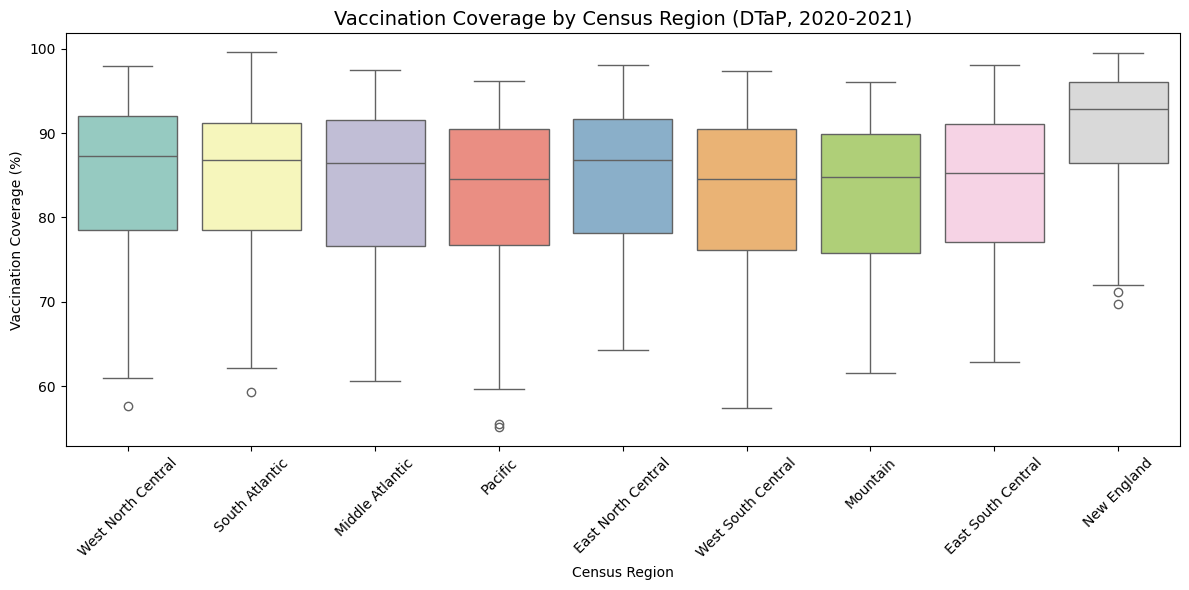

In [96]:


# Boxplot of vaccination coverage by Census Region
plt.figure(figsize=(12, 6))
sns.boxplot(x='Census Region', y='Estimate (%)', data=df_filtered, palette='Set3')
plt.xticks(rotation=45)
plt.title('Vaccination Coverage by Census Region (DTaP, 2020-2021)', fontsize=14)
plt.ylabel('Vaccination Coverage (%)')
plt.xlabel('Census Region')
plt.tight_layout()
plt.show()


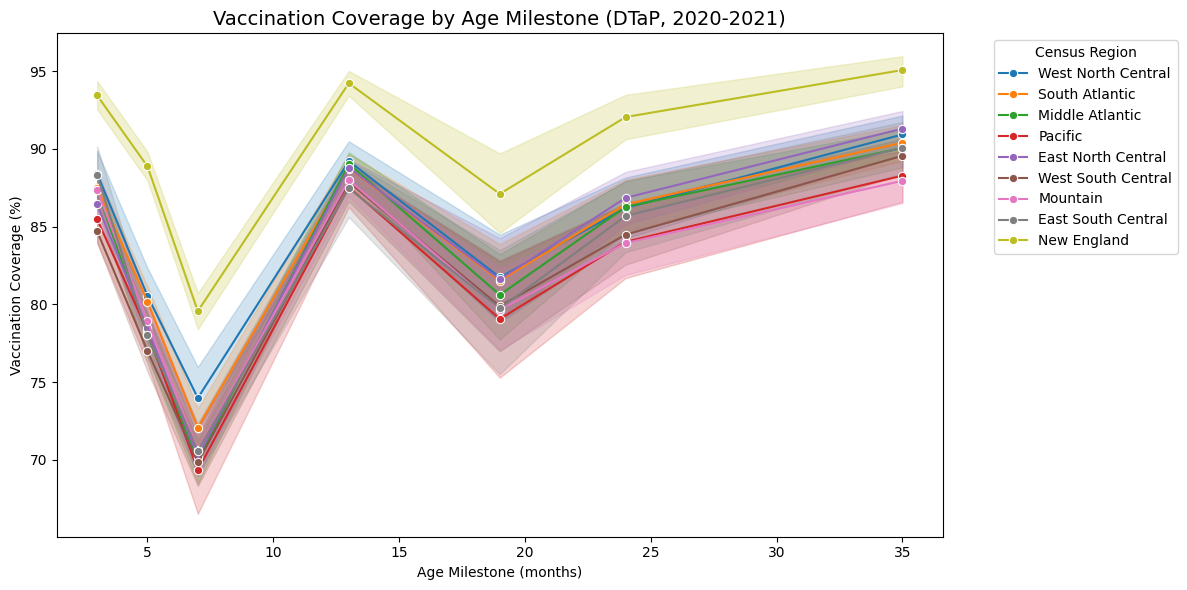

In [97]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_filtered, x='Age Milestone (months)', y='Estimate (%)', hue='Census Region', marker='o')
plt.title('Vaccination Coverage by Age Milestone (DTaP, 2020-2021)', fontsize=14)
plt.ylabel('Vaccination Coverage (%)')
plt.xlabel('Age Milestone (months)')
plt.legend(title='Census Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
